# Scaling behavior of self-avoiding polymers

Consider a self-avoiding polymer chain of $N$ monomers on a square lattice in two dimensions.

![SARW](SARW.png)

Our task is to calculate the average end-to-end distance, for simple sampling it is calculated as

$$ \langle R^2\rangle^\text{simple} = \frac{1}{M}\sum_{m=1}^{M}R_m^2. $$

For biased sampling it is calculated as

$$ \langle R^2\rangle^\text{biased} = \frac{\sum_{m=1}^{M}Q_mR^2_m}{\sum_{i=1}Q_m}\quad\text{with}\quad Q = \Pi_{i=1}^{N}\frac{l_i}{3}. $$

The sum appearing on the expression for $\langle R^2\rangle$ runs over _configurations_. The product appearing on the weight $Q$ runs over _steps_, with $l_i$ the number of possible moves at step $i$.

We like to use tuples as `V = (x=1, y=1)`. Let us define some useful operations

In [1]:
import Base.+
import Base.-
import Base.*
+(a::NamedTuple{(:x,:y),Tuple{Int64,Int64}}, b::NamedTuple{(:x,:y),Tuple{Int64,Int64}}) = (x=a.x + b.x, y=a.y + b.y)
-(a::NamedTuple{(:x,:y),Tuple{Int64,Int64}}, b::NamedTuple{(:x,:y),Tuple{Int64,Int64}}) = (x=a.x - b.x, y=a.y - b.y)
-(a::NamedTuple{(:x,:y),Tuple{Int64,Int64}}) = (x=-a.x, y=-a.y);

In [2]:
A = (x=1, y=1)
B = (x=2, y=2)
C = A + B
D = A - B
println(C) # addition
println(D) # substraction
println(-B) # unary minus
println(A.x)
println(B.x)

(x = 3, y = 3)
(x = -1, y = -1)
(x = -2, y = -2)
1
2


First we define a function that performs a single step of the walk

In [3]:
function one_step(r, moves_avail, lattice, weight, step, l)
    """ Generate one step of a self-avoiding random walk
    r = head position
    moves_avil = list of available moves
    lattice = 2N+1 lattice
    weight = walk weight probability
    step = step id
    l = head lattice id
    
    returns updated (r, moves_avil, lattice, weight, step)
    """
    moves_all = [(x=1,y=0), (x=-1,y=0), (x=0,y=1), (x=0,y=-1)] # list of all possible moves
    
    # update head position
    Δ = rand(moves_avail)
    r += Δ
    
    # update lattice
    lnew = l + Δ
    lattice[lnew.x, lnew.y] = 1
    
    # update weight
    weight *= length(moves_avail)/3.0
    
    # update available moves
    moves_avail = filter(x->( x!=-Δ ), moves_all)
    
    # update step
    step += 1
    
    return r, moves_avail, lattice, weight, step
end;

We define a function that returns the walk trajectory together with its associated weight

In [4]:
function single_biased_SARW(nsteps::Int64=10)
    """ Generate a single self-avoiding random walk using biased sampling
    nsteps = number of steps of the random walk
    
    Returns (random walk trajectory, number of rejections)
    """
    # Initialize position
    r     = (x=0, y=0) # head position
    r_vec = [(x=0, y=0)] # walk trajectory
    l0    = (x=nsteps+1, y=nsteps+1) # lattice id at the origin
    
    # Initialize lattice
    lattice = zeros(Int64, 2*nsteps+1, 2*nsteps+1) # 2N+1 square lattice
    lattice[l0.x, l0.y] = 1 # mark lattice at origin
    moves_all = [(x=1,y=0), (x=-1,y=0), (x=0,y=1), (x=0,y=-1)] # list of all possible moves
    
    weight = 1.0
    step = 0
    
    # First step
    r, moves_avail, lattice, weight, step = one_step(r, moves_all, lattice, weight, step, l0)
    push!(r_vec, r) # update trajectory
    
    # Iterate
    while true
        if step >= nsteps # enough steps?
            break
        else
            # update available moves
            l = l0 + r # lattice id
            for mov ∈ moves_avail
                lnew = l + mov # possible new lattice id
                if lattice[lnew.x, lnew.y] == 1 # is that lattice position occupied?
                    moves_avail = filter(x->( x!=mov ), moves_avail)
                end
            end
            
            if length(moves_avail) == 0 # completely blocked?
                break
            else
                r, moves_avail, lattice, weight, step = one_step(r, moves_avail, lattice, weight, step, l)
                push!(r_vec, r)
            end
        end
    end
    return r_vec, weight
end;

In [5]:
function single_simple_SARW(nsteps::Int64=10)
    """ Generate a single self-avoiding random walk using simple sampling
    nsteps = number of steps of the random walk
    
    Returns (random walk trajectory, number of rejections)
    """
    # Initialize position
    r     = (x=0, y=0) # head position
    r_vec = [(x=0, y=0)] # trajectory
    
    # Initialize lattice
    l0                  = (x=nsteps+1, y=nsteps+1) # lattice id at the origin
    lattice             = zeros(Int64, 2*nsteps+1, 2*nsteps+1) # 2N+1 square lattice
    lattice[l0.x, l0.y] = 1 # mark the lattice at the origin
    
    moves_all       = [(x=1,y=0), (x=-1,y=0), (x=0,y=-1), (x=0,y=1)] # list of all possible moves
    moves_avail     = [(x=1,y=0), (x=-1,y=0), (x=0,y=-1)] # available moves
    step            = 0 # step id
    weight::Float64 = 1.0 # weight of the random walk
    
    # Iterate
    while true
        if step >= nsteps # enough steps?
            break
        else
            Δ = moves_avail[rand(1:3)] # new step displacement
            l = l0 + r # lattice id
            lnew = l + Δ # new step lattice id
            if lattice[lnew.x, lnew.y] == 1 # occupied neighbour?
                break
            else
                lattice[lnew.x, lnew.y] = 1 # mark lattice at new id
                r += Δ # update head position
                push!(r_vec, r) # update trajectory
                step += 1 # update step id
                moves_avail = filter(x->( x!=-Δ ), moves_all) # update availabe moves
            end
        end
    end
    return r_vec, weight
end;


In [6]:
include("RandomWalk.jl")
using .RandomWalk: plot_single_walk
using Printf
using PyPlot

Simple walk terminated after 8 steps
Weight of the random walk Q=1.00000000


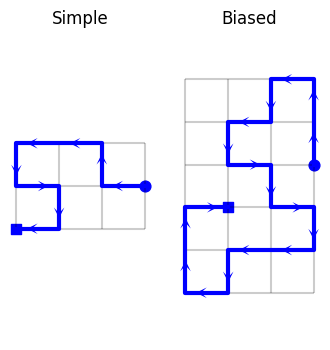

Biased walk terminated after 17 steps
Weight of the random walk Q=0.08779150


In [7]:
nsteps = 50

subplot(121)
r_vec, weight_simple = single_simple_SARW(nsteps)
x_vec = [r.x for r in r_vec]
y_vec = [r.y for r in r_vec]
terminated_simple = length(r_vec) - 1
plot_single_walk(x_vec, y_vec);
title("Simple")

subplot(122)
r_vec, weight_biased = single_biased_SARW(nsteps)
x_vec = [r.x for r in r_vec]
y_vec = [r.y for r in r_vec]
terminated_biased = length(r_vec) - 1
plot_single_walk(x_vec, y_vec);
title("Biased")

@printf("Simple walk terminated after %i steps\n", terminated_simple)
@printf("Weight of the random walk Q=%.8f\n",weight_simple)
@printf("Biased walk terminated after %i steps\n", terminated_biased)
@printf("Weight of the random walk Q=%.8f\n",weight_biased)

In [8]:
function sample_SARW(single_SARW, nsteps::Int64=50, nsamples::Int64=100)
    """ Sample the self-avoiding random walk
    single_SARW = function generating a single self-avoiding random walk
    nsteps = number of steps of the walk
    nsamples = number of samples
    
    Returns (<r²>, <r⁴>, number of terminations, number of rejections)
    """
    r2av_vec = zeros(Float64, nsteps)
    nsamples_vec = zeros(Int64, nsteps)
    nterminations_vec = zeros(Int64, nsteps)
    weight_vec = zeros(Float64, nsteps)
    
    for n ∈ 1:nsteps # loop over steps
        
        s = 0 # sample id
        while s < nsamples # loop over samples
            traj, weight = single_SARW(n) # generate single walk (get corresponding weight)
            
            if length(traj) - 1 == n # has the walk terminated at step n?
                rfin = last(traj) # end point of the walk
                r2 = rfin.x^2 + rfin.y^2
                r2av_vec[n] += weight*r2
                weight_vec[n] += weight
                s += 1
                
            else # walk terminated earlier
                nterminations_vec[n] += 1
            end
            
        end
        
    end
    
    r2av_vec ./= weight_vec;
    return r2av_vec, nterminations_vec
end;

Sample single and biased self-avoiding random walks

In [9]:
nsteps = 50
nsamples = 1000
r2av_vec_simple, nterminations_simple = sample_SARW(single_simple_SARW, nsteps, nsamples);
r2av_vec_biased, nterminations_biased = sample_SARW(single_biased_SARW, nsteps, nsamples);

No we plot $N$ vs $<R^2>$

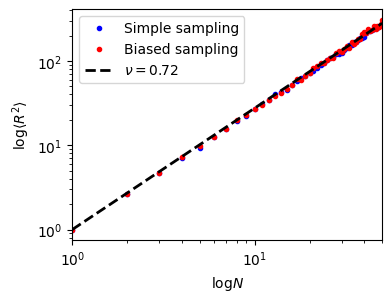

In [10]:
PyPlot.rc("figure", figsize = (4, 3))

step_vec = [s for s ∈ 1.0:1.0:nsteps]
linear = [s^(2*0.72) for s ∈ step_vec]

loglog(step_vec, r2av_vec_simple, lw=0, c="b", marker=".", label="Simple sampling")
loglog(step_vec, r2av_vec_biased, lw=0, c="r", marker=".", label="Biased sampling")
loglog(step_vec, linear, c="k", lw=2, ls="--", label=L"$\nu=0.72$")

xlim(first(step_vec), last(step_vec))

xlabel(L"\log N")
ylabel(L"\log\langle R^2\rangle")
legend();

Check the number of terminations and number of rejections

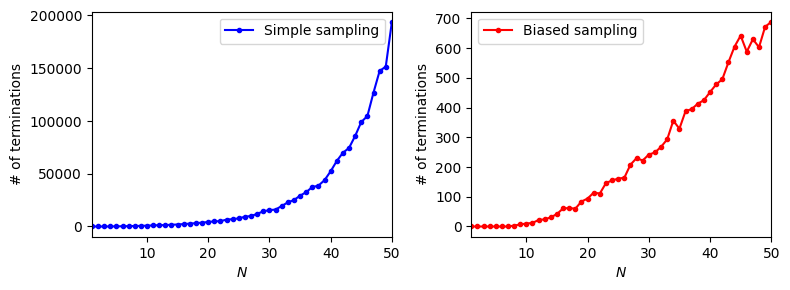

In [11]:
PyPlot.rc("figure", figsize = (8, 3))

subplot(121)
plot(step_vec, nterminations_simple, marker=".", c="b", label="Simple sampling")

xlim(first(step_vec), last(step_vec))
xlabel(L"N")
ylabel("# of terminations")
legend();

subplot(122)
plot(step_vec, nterminations_biased, marker=".", c="r", label="Biased sampling")

xlim(first(step_vec), last(step_vec))
xlabel(L"N")
ylabel("# of terminations")
legend();

tight_layout()